In [105]:
import json

import bz2
import regex
import gensim
from tqdm.notebook import tqdm
from scipy import sparse
import numpy as np
from pymystem3 import Mystem
from pandarallel import pandarallel
from gensim.models import word2vec
from nltk.tokenize import sent_tokenize, RegexpTokenizer
import urllib.request
from sklearn.decomposition import TruncatedSVD
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
pandarallel.initialize(nb_workers=4, use_memory_fs=True, progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [100]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import FreqDist
from tqdm import tqdm_notebook as tqdm
from sklearn.manifold import TSNE

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

#  Домашнее задание по NLP # 2 [100 баллов] 
## Составление словарей для классификации по тональности
При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: "теплое пиво" – это плохо, а "теплый свитер" – это хорошо.  

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).


Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

In [4]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Обучение модели word2vec [100 баллов]

1. Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова. 
2. Обучите по коллекции предложений word2vec
3. Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    * тест на определение ближайших слов
    * тест на аналогии (мужчина – король : женщина – королева)
    * тест на определение лишнего слова.
    
4. Постройте несколько визуализаций:
    * TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    * задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.  Более формально:
    берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  
 


Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

In [5]:
responses_frame = pd.DataFrame(responses)
responses_frame.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN


In [6]:
regex = re.compile("[А-Яа-я]+")
def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

corp_ = responses_frame.text.str.lower()
corp_ = corp_.parallel_apply(words_only)
corp_

0         добрый день я не являюсь клиентом банка и пору...
1         доброго дня являюсь держателем зарплатной карт...
2         здравствуйте дублирую свое заявление от в до м...
3         добрый день я открыл расчетный счет в сбербанк...
4         г взяла кредит в вашем банке заявленная мною с...
                                ...                        
153494    слишком большой банк не всегда учитывает нашу ...
153495    вы сами виноваты в своих проблемах кроме предп...
153496    уважаемое руководство банка овк я проживаю в г...
153497    пробовала оформить товар в кредит в альфа банк...
153498    если коротко то мне нравится кридит получать м...
Name: text, Length: 153499, dtype: object

In [61]:
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "
corpus_lemmatized = pd.DataFrame(corp_).text.parallel_apply(lemmatize)
corpus_lemmatized[:5]

0    добрый день я не являться клиент банк и поручи...
1    добрый день являться держатель зарплатной карт...
2    здравствовать дублировать свой заявление от в ...
3    добрый день я открывать расчетный счет в сберб...
4    г взять кредит в ваш банк заявлять я сумма быт...
Name: text, dtype: object

In [62]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian')+ ['это', 'наш' , 'тыс', 'млн', 
                                           'млрд', 'также',  'т', 'д', 'г',
                                           'который', 'весь', 
                                          ]
print(mystopwords)
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [63]:
corpus_lemmatized = corpus_lemmatized.parallel_apply(remove_stopwords)  

In [29]:
urllib.request.urlretrieve("http://rusvectores.org/static/models/rusvectores2/ruscorpora_mystem_cbow_300_2_2015.bin.gz", "ruscorpora_mystem_cbow_300_2_2015.bin.gz")

('ruscorpora_mystem_cbow_300_2_2015.bin.gz',
 <http.client.HTTPMessage at 0x7f8fc038a550>)

In [46]:
model_path = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'

model_ru = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [50]:
model_ru.similarity('человек_S', 'обезьяна_S')

0.2389561

In [65]:
corpus = []
punct = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~„“«»†*—/\-‘’'

for sent in tqdm(corpus_lemmatized):
    s = [w.lower().strip(punct) for w in sent.split()]
    corpus.append(s)
    
print(corpus[:2])


[['добрый', 'день', 'являться', 'клиент', 'банк', 'поручитель', 'кредитный', 'договор', 'являться', 'либо', 'лицо', 'письменно', 'оформлять', 'отношение', 'банк', 'повод', 'урегулирование', 'чей', 'либо', 'задолженность', 'начинать', 'март', 'год', 'начинать', 'приходить', 'бесконечный', 'письмо', 'ооо', 'примо', 'коллект', 'адрес', 'город', 'москва', 'уваровский', 'переулок', 'дом', 'квартира', 'угроза', 'возбуждение', 'уголовный', 'дело', 'отношение', 'гражданин', 'филиппов', 'эдуард', 'владимирович', 'уклоняться', 'уплата', 'взять', 'кредит', 'договор', 'год', 'договор', 'год', 'ответственность', 'хотеть', 'заверять', 'вышеуказанный', 'гражданин', 'разыскивать', 'знакомый', 'адрес', 'зарегистрировать', 'образ', 'удостоверяться', 'подлинность', 'документ', 'оформлять', 'имя', 'кредитный', 'договор', 'меньший', 'мера', 'понятно', 'почему', 'ваш', 'милость', 'должный', 'переживать', 'бояться', 'свой', 'имущество', 'письмо', 'доставлять', 'серьезный', 'неудобство', 'нарушать', 'граждан

In [67]:
print("Training model...")

%time model_ru = word2vec.Word2Vec(corpus, workers=4, size=300, min_count=10, window=10, sample=1e-3)

Training model...
CPU times: user 22min 1s, sys: 3.57 s, total: 22min 5s
Wall time: 5min 58s


In [76]:
model_ru.similarity('дом', 'квартира')

/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.32574564

In [77]:
model_path = "model.model"

print("Saving model...")
model_ru.save(model_path)

Saving model...


In [78]:
# дообучаем

model = word2vec.Word2Vec.load(model_path)

model.build_vocab(corpus, update=True)
model.train(corpus, total_examples=model.corpus_count, epochs=5)

(95419209, 105425140)

In [79]:
model.similarity('дом', 'квартира')

/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.327334

### Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    тест на определение ближайших слов
    тест на аналогии (мужчина – король : женщина – королева)
    тест на определение лишнего слова.


In [99]:
print(model.wv.most_similar(positive=["вред", "заявление"], topn=1))
print(model.wv.most_similar(positive=["клиент", "фамилия"], topn=1))

print(model.wv.most_similar(positive=['документ', 'муж'], negative=["необходимый"], topn=1))

print(model.wv.most_similar("клиент", topn=3))

print(model.wv.doesnt_match(['уплата', 'взять', 'кредит', 'договор', 'карта', 'договор', 'год', 'ответственность']))

[('ущерб', 0.5527088642120361)]
[('имя', 0.4184782803058624)]
[('жена', 0.4990273714065552)]
[('клиенто', 0.5584724545478821), ('вкладчик', 0.5337014198303223), ('клиентоориентированный', 0.4571387767791748)]
ответственность


В целом, модель достаточно омысленна,


    "вред" + "заявление" = 'ущерб'
    'документ' +  'муж' - "необходимый" = "жена"
    "клиент" = 'вкладчик'
    
а в списке

    ['уплата', 'взять', 'кредит', 'договор', 'карта', 'договор', 'год','ответственность']
    
'ответственность' лишнее

### Постройте несколько визуализаций:
    * TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    * задайте координаты для нового пространства следующим образом: одна  ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.  Более формально:
    берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.  
 

In [101]:
top_words = []

fd = FreqDist()
for s in tqdm(corpus):
    fd.update(s)

for w in fd.most_common(1000):
    top_words.append(w[0])
    
print(top_words[:50:])
top_words_vec = model[top_words]

/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



['банк', 'карта', 'деньги', 'день', 'кредит', 'отделение', 'клиент', 'сотрудник', 'счет', 'мочь', 'свой', 'сказать', 'сумма', 'получать', 'заявление', 'год', 'вопрос', 'время', 'кредитный', 'приходить', 'ответ', 'вклад', 'офис', 'телефон', 'данный', 'платеж', 'договор', 'ваш', 'номер', 'звонить', 'банкомат', 'сбербанк', 'очень', 'позвонить', 'месяц', 'написать', 'проблема', 'обращаться', 'решать', 'работать', 'средство', 'рубль', 'работа', 'документ', 'ситуация', 'звонок', 'отвечать', 'говорить', 'человек', 'хотеть']


/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [103]:
svd_50 = TruncatedSVD(n_components=50)
top_words_vec_50 = svd_50.fit_transform(top_words_vec)
top_words_tsne2 = TSNE(n_components=2, random_state=0).fit_transform(top_words_vec_50)

In [107]:
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE (eng model, top1000 words, +SVD)")

source = ColumnDataSource(data=dict(x1=top_words_tsne2[:,0],
                                    x2=top_words_tsne2[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=11, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

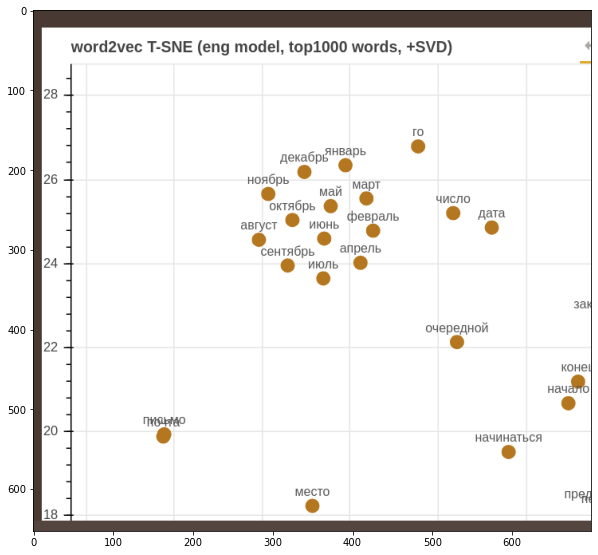

In [120]:
# хорошо выглядит кластер с месяцами
import cv2
plt.figure(figsize=(10,10))

plt.imshow(cv2.imread('Снимок экрана от 2021-05-13 18-08-28.png')[400:1200,300:1000])

In [125]:
banks = responses_frame.bank_name.unique()
len(top_words), len(banks)

(1000, 670)

In [135]:
diff_fast = model["быстро"] - model["медленно"]
diff_good = model["плохой"] - model["хороший"]

/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [142]:
top_words_vec.shape, diff_fast.shape, len(top_words)

((1000, 300), (300,), 1000)

In [145]:
top_words_vec * diff_fast

array([[ 2.3245342 , -0.87534326, -0.69112736, ..., -0.3485093 ,
         1.3892802 , -0.20669232],
       [-0.28513187,  9.498124  ,  4.2967496 , ...,  0.27927348,
        -0.29266706,  0.12316088],
       [-2.1413662 , -0.512876  ,  0.5291108 , ...,  2.2978601 ,
        -0.30801395,  0.24167815],
       ...,
       [ 2.7039478 , -5.6695848 ,  2.042364  , ..., -0.97082835,
        -0.79992115,  0.09881004],
       [-2.4226043 ,  5.697796  , -0.6303951 , ...,  0.30345148,
         1.0623392 , -0.11263178],
       [-0.03232608, -2.644978  , -2.5710123 , ...,  0.42045417,
        -1.1551265 , -0.1326247 ]], dtype=float32)

In [144]:
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE (eng model, top1000 words, +SVD)")

source = ColumnDataSource(data=dict(x1=top_words_tsne2[:,0],
                                    x2=top_words_tsne2[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=11, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


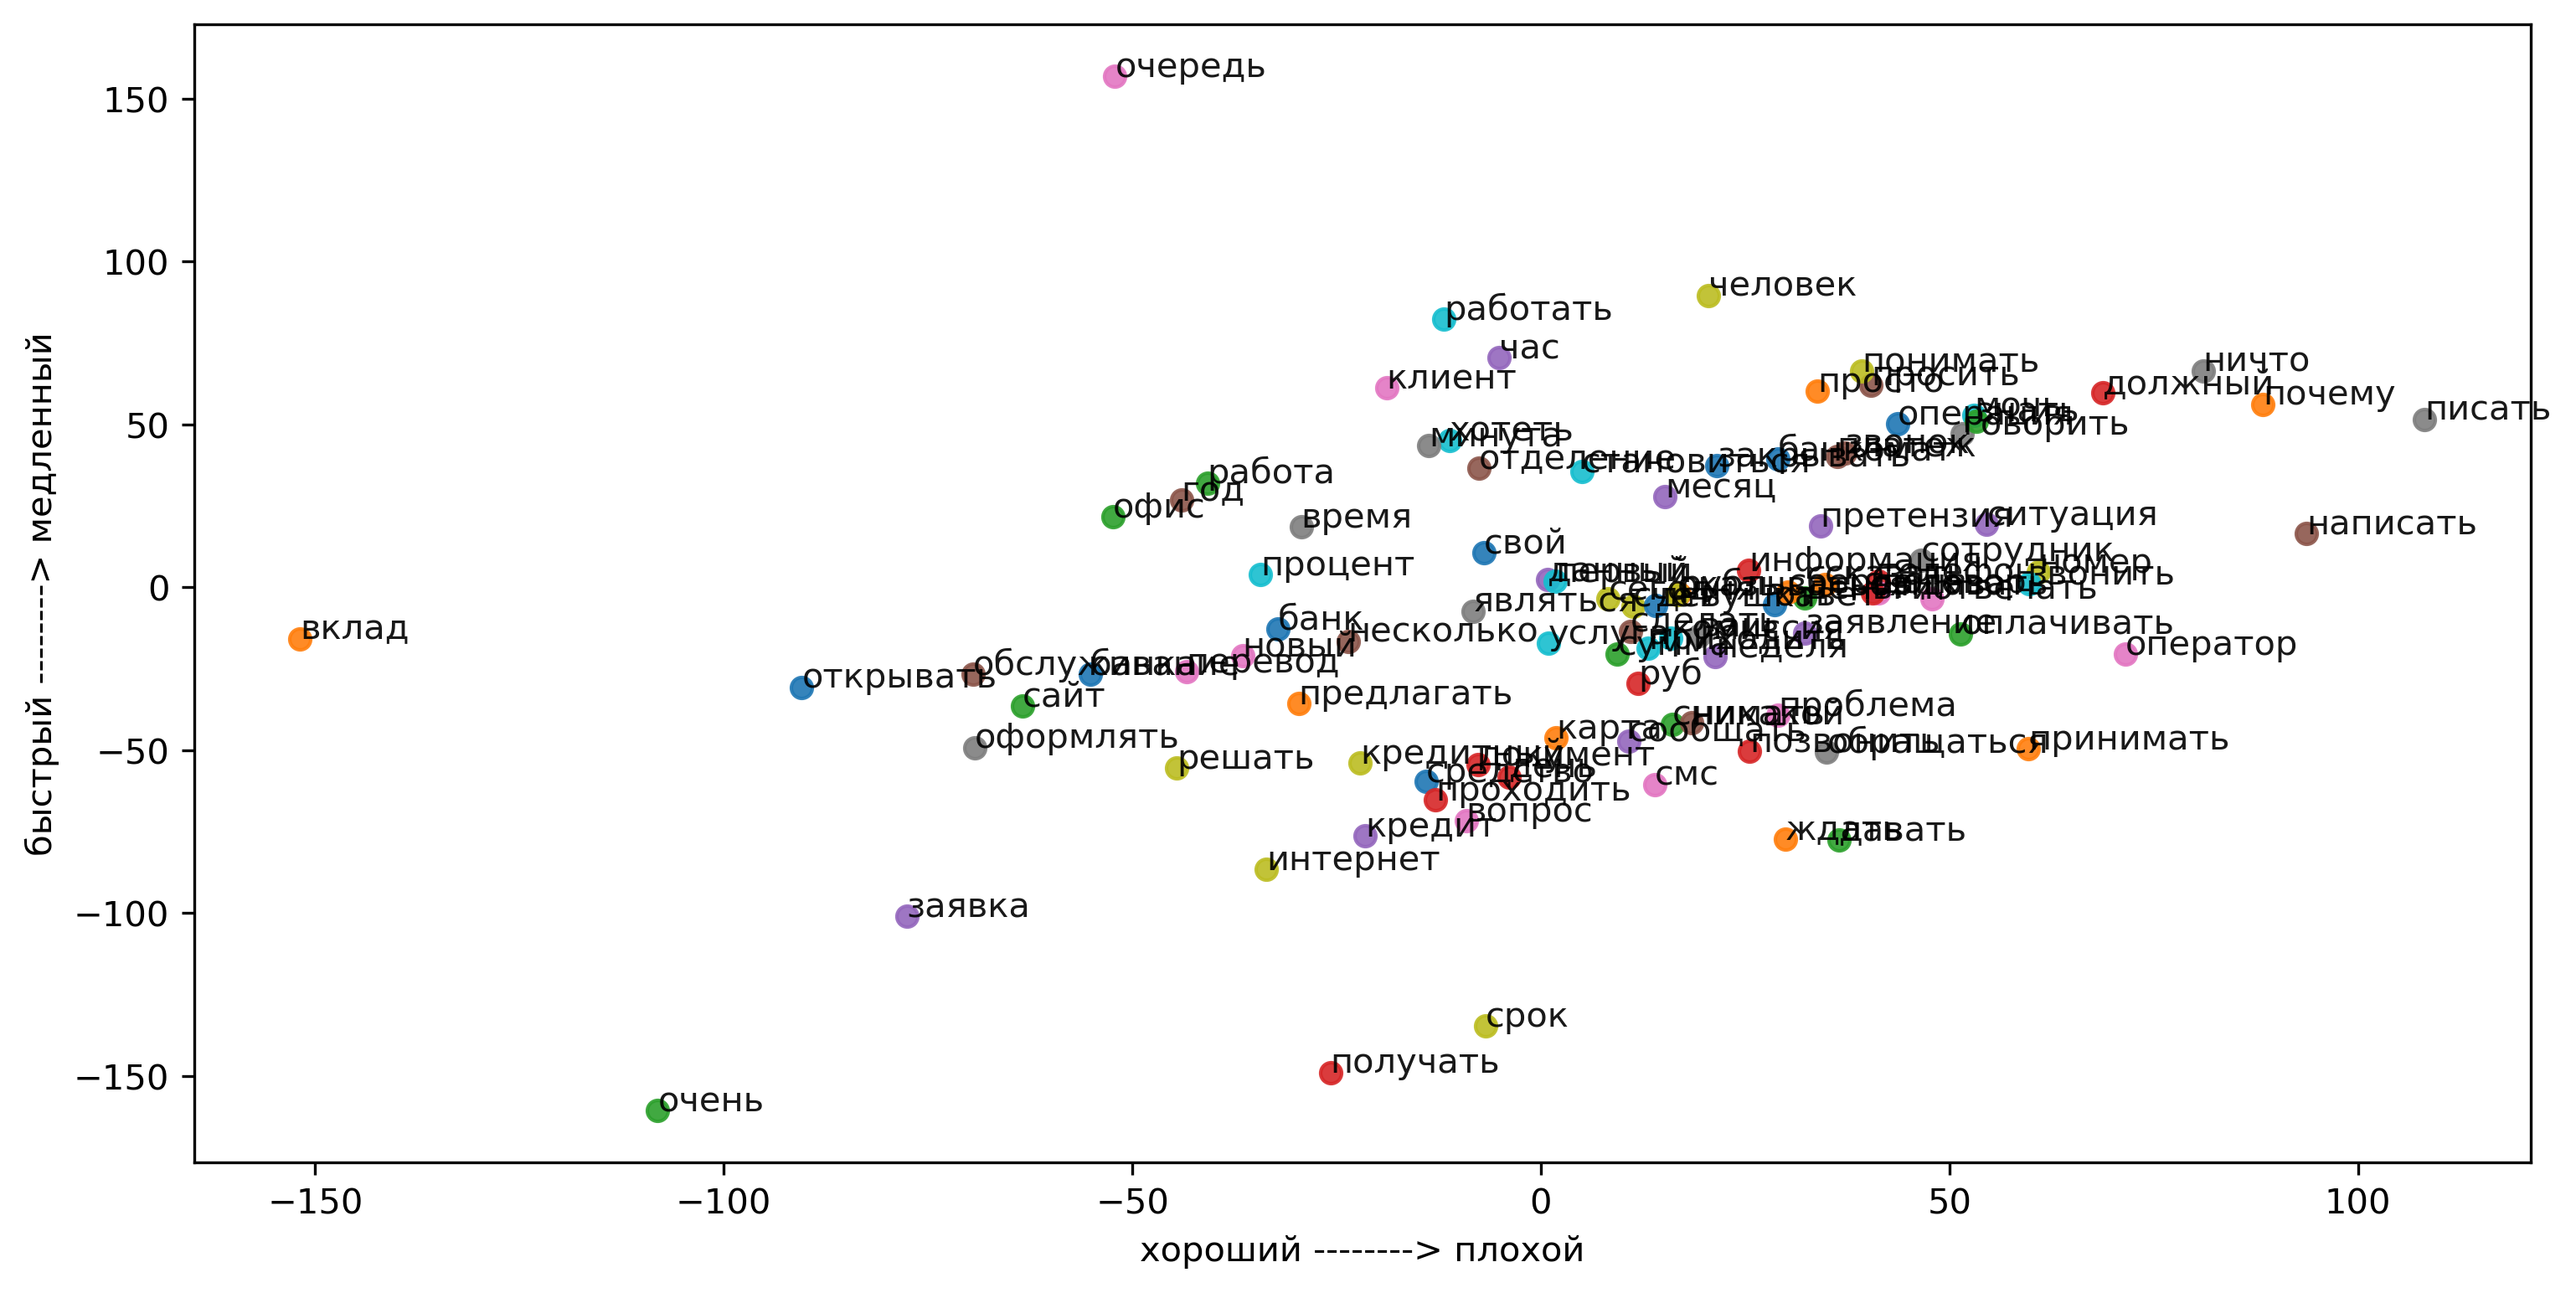

In [160]:
colors = plt.cm.tab20.colors

def word2viz_plot(words, x_op, y_op):
    """Plot selected words on a 2-D plane
      Each word gets its coordinates x and y from
      its dot product with the vector differences x_op, and y_op
    """
    dfs = model[words]
    x2, x1 = x_op.split(" - ")
    y2, y1 = y_op.split(" - ")
    x_label = "%s --------> %s" % (x1, x2)
    y_label = "%s --------> %s" % (y1, y2)
    
    word_labels = words # dfs.index if labels is None else labels

    diff_fast = model[x2] - model[x1]
    diff_good = model[y2] - model[y1]
    dfs_x = dfs.dot(diff_fast)
    dfs_y = dfs.dot(diff_good)

    fig = plt.figure(figsize=(12,6), dpi=300)
    ax = fig.add_subplot(1,1,1)

    for i in range(len(dfs)):
        x, y, text = dfs_x[i], dfs_y[i], word_labels[i]
        ax.scatter(x, y, alpha=0.9,);
        ax.text(x, y, text, alpha=0.9,); #  color=colors[i%20]

    ax.set_xlabel(x_label);
    ax.set_ylabel(y_label);

    plt.show();
    
word2viz_plot(top_words[:100], "плохой - хороший", "медленный - быстрый")

В общем выглядит вполне неплохо, попробуем для названий некоторых банков

In [174]:
pd.Series(banks).unique()[:20]

array(['Бинбанк', 'Сбербанк России', 'ОТП Банк', 'Гагаринский',
       'Тинькофф Банк', 'Восточный Экспресс Банк', 'ВТБ 24', 'Альфа-Банк',
       'БИНБАНК кредитные карты', 'МТС Банк', 'Совкомбанк',
       'Россельхозбанк', 'Московский Кредитный Банк', 'МДМ Банк',
       'Хоум Кредит Банк', 'Бенифит-Банк',
       'Уральский Банк Реконструкции и Развития', 'Русский Стандарт',
       'Лето Банк', 'Петрокоммерц'], dtype=object)

In [177]:
banks_ = ["россельхозбанк", "сбербанк", "совкомбанк", "росавтобанк",
          "русский", "петрокоммерц", "бинбанк", "тинькофф",
          "уральский", "лето"]

/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/home/dmi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


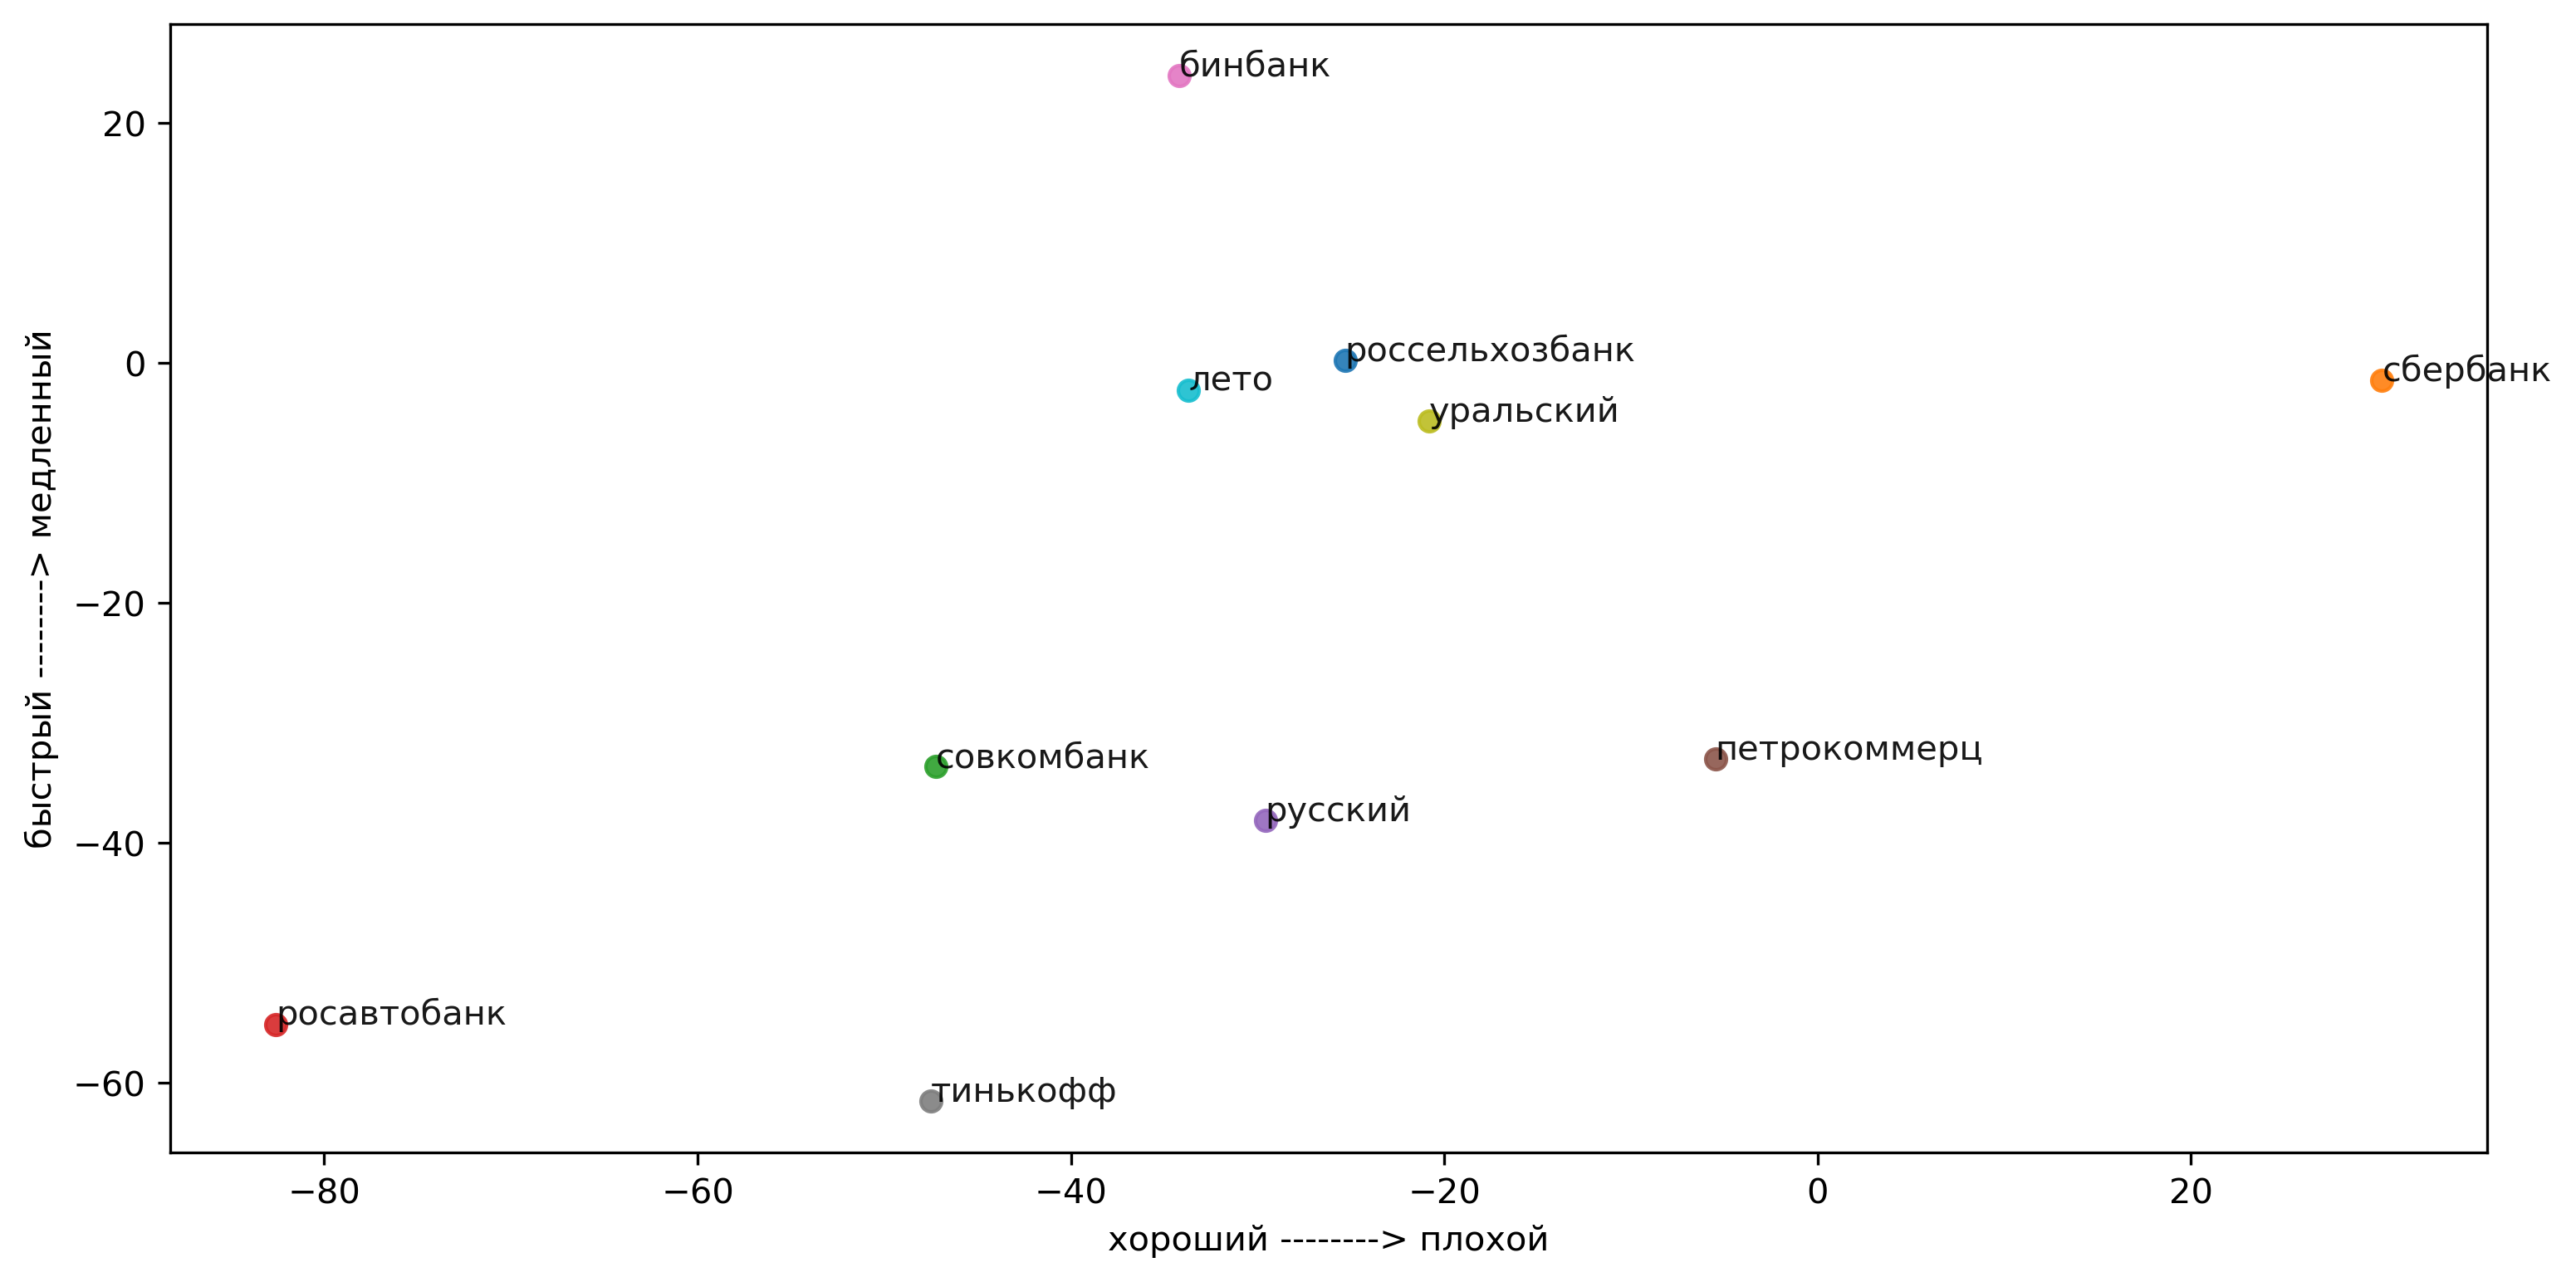

In [178]:
word2viz_plot(banks_, "плохой - хороший", "медленный - быстрый")

Возможно Сбербанк самый "плохой" банк из-за того, что он самый крупный на него больше всего отзывов.